In [3]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/philhoonoh/os/blob/main/lecture_summary/07_Chapter7.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Chapter 7. Synchronization Examples
#### Contents
    - 7.1 Synchronization Examples
    - 7.5 Alternative Approaches

# 7.1 Classic Problems of Synchronization
- 3 types of classic problems of synchronization
     - __7.1.1 Bounded-Buffer__ Problem
     - __7.1.2 Readers–Writers__ Problem
     - __7.1.3 Dining-Philosophers__ Problem

# 7.1.1 Bounded-Buffer Problem
- Producer-Consumer Problem with bounded buffer
    - n buffers, each capable of holding one item
- producer : produces full buffers for the consumer
- consumer : produces empty buffers for the producer


```c
int n;
semaphore mutex = 1;
semaphore empty = n;
semaphore full = 0;
```

- semaphore mutex : mutual exclusion for accesses to the buffer pool
- semaphore empty : used for counting the number of empty buffers; initialized to _n_
- semaphore full : used for counting the number of full buffers; initialized to _0_
    
### The structure of the producer process
```c
while (true) {
        ...
    /* produce an item in next_produce */
        ...
    wait(empty); // wait until buffer is emptied
    wait(mutex); // only one thread can access the buffer pool
        ...
    /* add next_produced to the buffer */
        ...
    signal(mutex); // release mutex on buffer pool
    signal(full); // signal buffer is full
}
```



### The structure of the consumer process
```c
while (true) {
    wait(full); // wait until buffer is full
    wait(mutex); // only one thread can access the buffer pool
        ...
    /* remove an item from buffer to next_consumerd */
        ...
    signal(mutex); // release mutex on buffer pool
    signal(empty); // signal buffer is emptied
        ...
    /* consume the item in next_consumed */
        ...
}
```

-  note that structure of producer and consumer is symmertric

### PThread solution to the Bounded-Buffer Problem
```c
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h> 
#include <pthread.h> 
#include <semaphore.h>

#define true 1
#define BUFFER_SIZE 5

int buffer[BUFFER_SIZE];

pthread_mutex_t mutex;
sem_t empty, full;

int in = 0, out = 0;

void *producer(void *param) {
    int item;
    while(true){
        usleep((1 + rand() % 5) * 100000);
        item = 1000 + rand() % 1000;
        insert_item(item); // critical section
    }
}

void *consumer(void *param) {
    int item;
    while (true) {
        usleep((1 + rand() % 5) * 100000);
        remove_item(&item); // critical section         
    }
}

void insert_item(int item){
    sem_wait(&empty);
    pthread_mutex_lock(&mutex);
    
    buffer[in] = item;
    in = (in + 1) % BUFFER_SIZE;
    printf("Producer: inserted $ %d\n", item);
    
    pthread_mutex_unlock(&mutex);
    sem_post(&full);
}

void remove_item(int *item){
    sem_wait(&full)
    pthread_mutex_lock(&mutex);
    
    *item = buffer[out];
    out = (out + 1) % BUFFER_SIZE;
    printf("Consumer: removed $ %d\n", *item);
           
    pthread_mutex_lock(&mutex);
    sem_post(&emtpy)
}
           
int main(int argc, char *argv[]) {
    int i, numOfProducers = 1, numOfConsumers = 1;
    pthread_t tid;
 
    pthread_mutex_init(&mutex, NULL);
    sem_init(&empty, 0, BUFFER_SIZE);
    sem_init(&full, 0, 0);
    srand(time(0));
    // Create the producers
    for (i = 0; i < numOfProducers; i++)
        pthread_create(&tid, NULL, producer, NULL);
    // Create the consumers
    for (i = 0; i < numOfConsumers; i++) 
        pthread_create(&tid, NULL, consumer, NULL);
    sleep(10);
    return 0;
}
```

### Java solution to the Bounded-Buffer Problem
```java
public class BoundedBuffer {
    public static void main(String[] args) {
        CashBox cashBox = new CashBox(1);
        Thread[] producers = new Thread[1];
        Thread[] consumers = new Thread[1];
        
        // Create threads of producers
        for (int i = 0; i < producers.length; i++) { 
            producers[i] = new Thread(new ProdRunner(cashBox)); 
            producers[i].start();
        }
        // Create threads of consumers
        for (int i = 0; i < consumers.length; i++) {
            consumers[i] = new Thread(new ConsRunner(cashBox)); 
            consumers[i].start();
        }
    }
}

class ProdRunner implements Runnable {
    CashBox cashBox;

    public ProdRunner(CashBox cashBox) {
        this.cashBox = cashBox;
    }
    @Override
    public void run() { 
        try {
            while (true) {
                Thread.sleep((long)(Math.random()*500));
                int money = ((int)(1 + Math.random()*9))*10000; 
                cashBox.give(money);
            }
        } catch (InterrupedException e) {}
    }          
} 

class ConsRunner implements Runnable { 
    CashBox cashBox;
    public ConsRunner(CashBox cashBox) {
        this.cashBox = cashBox;
    }

    @Override

    public void run() { 
        try {
            while (true) {
                Thread.sleep((long)(Math.random()*500));
                int money = cashBox.take();
            }
        } catch (InterruptedException e) {}
    }
} 

class CashBox {
    private int[] buffer;
    private int count, in, out;
    public CashBox(int bufferSize) {
        buffer = new int[bufferSize];
        count = in = out = 0;
    }

    synchronized public void give(int money) {
        while (count == buffer.length) {
            try { 
                wait();
            }
            catch (InterruptedException e) {}
        }

        buffer[in] = money;
        in = (in + 1) % buffer.length;
        count++;
        System.out.printf("give allowance: %d dollar\n", money);
        
        notify();
    }
    
    synchronized public int take() throws InterruptedException {
        while (count == 0) {
            try {
                wait();
            }
            catch (InterruptedException e) {}
        }
        
        int money = buffer[out];
        out = (out + 1) % buffer.length;
        count--;
        System.out.printf("take allowance: %d dollar\n", money);
        
        notify();
        return money;
    }
}
```

#  7.1.2 Readers–Writers
- Several concurrent processes accesing shared data(such as database) is either _readers_ or _writers_
    - __readers__ : only read data
    - __writers__ :  update(read & write) the data 


- two or more readers accessing shared data simultaneously 
    - no adverse affects
- writer + other processes(either reader or writer) accessing shared data simultaneously 
    - ensuing chaos!
    
    
### Variations of readers-writers problem
- all involved with priority (which one goes first? reader or writer?)

#### First readers-writers problem
- readers-preference : simply, _readers_ (concurrently) goes first
    - 엄밀하게 말하자면, 어떤 reader thread 하나가 lock을 획득하면, 다른 reader 들은 기다릴 필요 없이 shared data에 접근해도 됨.
    - 위의 연산이 끝마치고, waiting queue 에 writier, reader threads 가 있다면, <span style="color:red">__job scheduler 에 의해 하나 선택__ (readers-preference 라고 해서 reader 라고 하면 안됨)</span>
        - case1) reader thread 가 선택 되면, 다른 reader 들도 득달같이 달려들어서 shared data에 접근
        - case2) writer thread 가 선택. (굳) 

- no reader should wait for other readers to finish simply because a writer is waiting
    - no reader shall be kept waiting if the share data is currently opened for reading 
    - multiple reader threads can read simultaneously because concurrent reads are safe
    - R1 reader thread 가 shared data 에 access 한다면, 다른 reader threads 또한 기다릴 필요 없이 shared data 에 access 가능 WHY? reader 는 thread-safe 하므로.
- __starvation__ on writers
    - think of massive amounts of reader threads are in the queue & keep adding readers

#### Second readers-writers problem
- writers-preference : simply, _writers_ go first
- if a writer is waiting to access the object, no new readers may start reading
- __starvation__ on readers
    - think of massive amounts of writer threads are in the queue & keep adding writers
    
### Solution for first readers–writers problem
```c
semaphore rw_mutex = 1;
semaphore mutex = 1;
int read_count = 0;
```
- rw mutex (binary semaphores) : common to both readers and writers
    - mutual exclusion semaphore for the writers
        - One writer at a time for accessing shared data
    - used by the first or last reader that enters or exits the critical section
        - First reader __acquire__ rw_mutex -> others readers are able to access the shared data as well -> Last reader __release__ rw_mutex
        - In this case, it will be wait & singal functions
- mutex (binary semaphores) : mutual exclusion when the variable read_count is updated
- read_count : keeps track of how many processes are currently reading the object

#### structure of a writer process (first readers–writers problem)
```c
while (true) {
    wait(rw_mutex);
        ...
    /* writing is performed */
        ... 
    signal(rw_mutex);
}
````

#### structure of a reader process (first readers–writers problem)
```c
while (true) {
    wait(mutex); /* waiting mutex for updating read_count variable */
    read_count++;
    if (read_count == 1) /* read_count == 1, meaning this is the first reader */
        wait(rw_mutex); /* wait for rw_mutex, meaning waiting for writer to finish or the last reader of previous readers process to finish */
    signal(mutex); /* singal mutex for other readers to approach read_count variable */
        ...
    /* reading is performed */
        ... 
    wait(mutex); /* waiting mutex for updating read_count variable */
    read count--;
    if (read count == 0) /* read_count == 0, meaning this is the last reader */
        signal(rw mutex); /* signal rw_mutex for writer or new fisrt reader process */
    signal(mutex); /* singal mutex for other readers to approach read_count variable */
}
```

- if a writer is in the critical section
    - n readers are waiting
    - then one reader is queued on rw mutex
    - and n − 1 readers are queued on mutex
    
    
- Also observe that, when a writer executes signal(rw mutex)
    - we may resume the execution of either the waiting readers or a single waiting writer. The selection is made by the scheduler

### Reader-Writer Locks
- Synchronization primitive for readers–writers problems and its solutions 
- Acquiring a reader-writer lock requires specifying the mode of the lock: either __read__ or __write__ access
    - multiple processes may acquire a reader-writer lock in read mode
    - only one process may acquire the lock for writing for exclusive access


### Java solution to the first Readers-Writers Problem
```java
class SharedDB {
    private int readerCount = 0;
    private boolean isWriting = false;
    
    public void read() {
        // read from the database here.
    }
    
    public void write() {
        // write into the database here.
    }
    
    synchronized public void acquireReadLock() {
        while (isWriting == true) {
            try{
                wait();
            } catch (InterruptedException e) {}
        }
        readerCount++;
    }
    
    synchronized public void releaseReadLock() {
        readerCount--;
        if (readerCount == 0)
            notify();
    }
    
    synchronized public void acquireWriteLock() {
        while(readerCount > 0 || isWriting == true) {
            try{
                wait();
            } catch (InterruptedException e) {}
        }
        isWriting = true;
    }
    
    synchronized public void releaseWriteLock() {
        isWriting = true;
        notifyAll();
    }
}
```

#  7.1.3 Dining-Philosophers Problem
- represent how to allocate several resources among several processes in a deadlock-free and starvation-free manner

### The situation of the dining philosophers
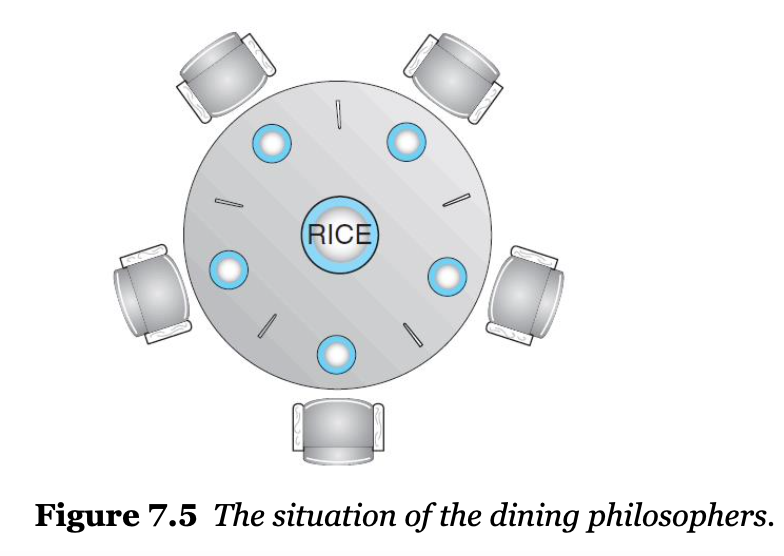
- Consider five philosophers who spend their lives thinking and eating
- Table is laid with five single chopsticks
- Philosopher gets hungry and tries to pick up the two chopsticks that are closest to her (the chopsticks that are between her and her left and right neighbors)
- She cannot pick up a chopstick that is already in the hand of a neighbor
- Hungry philosopher has both her chopsticks at the same time, she eats without releasing the chopsticks

### Solution1 - Semaphore Solution
- represent each chopstick with a semaphore
    - A philosopher acquires a chopstick by executing a 𝑤𝑎𝑖𝑡() operation
    - She releases her chopsticks by executing a 𝑠𝑖𝑔𝑛𝑎𝑙() operation

#### Semaphore solution example
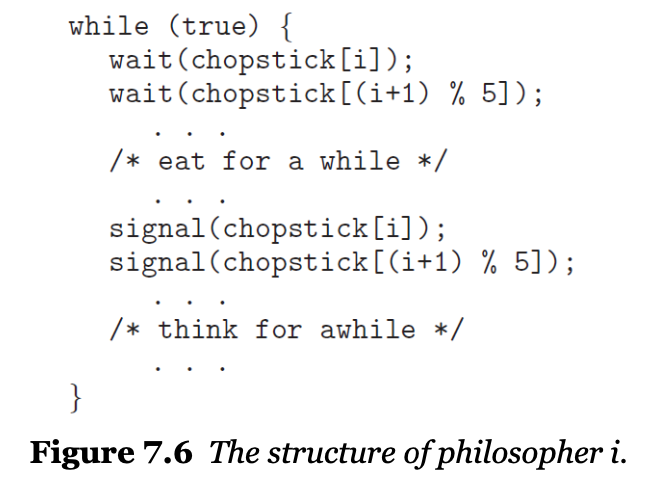

#### Limitation of Solution1 - Semaphore Solution
- Simple semaphore solution guarantees mutual exclusion
- it could create deadlock or starvation
    - Suppose that all five philosophers become hungry at the same time
    - Each grabs her left chopstick
    - All the elements of chopstick will now be equal to 0
    - Here comes a deadlock situation
    
### Alternative Solutions for Solution1
- deadlock-free solutions
- deadlock-free solution does not necessarily eliminate the possibility of starvation

#### Method 1. At most four philosophers to be sitting simultaneously at the table
#### Method 2. Pick up her chopsticks only if both chopsticks are available
#### Method 3. Asymmetric solution
    - odd-numbered philosopher picks up first her left chopstick and then her right chopstick
    - even-numbered philosopher picks up her right chopstick and then her left chopstick


### Method 2 (Alternative Solution) - Monitor Solution
- Imposes the restriction that a philosopher may pick up her chopsticks only if both of them are available
- Distinguish among three states of the philosophers: 
    - thinking, hungry, and eating
- Philosopher can set her state to be eating only if her two neighbors are not in the state of eating
- Condition variable
    - Philosopher i to delay herself when she is hungry but is unable to obtain the chopsticks she needs
    
### Method 2 (Alternative Solution) - Monitor Solution
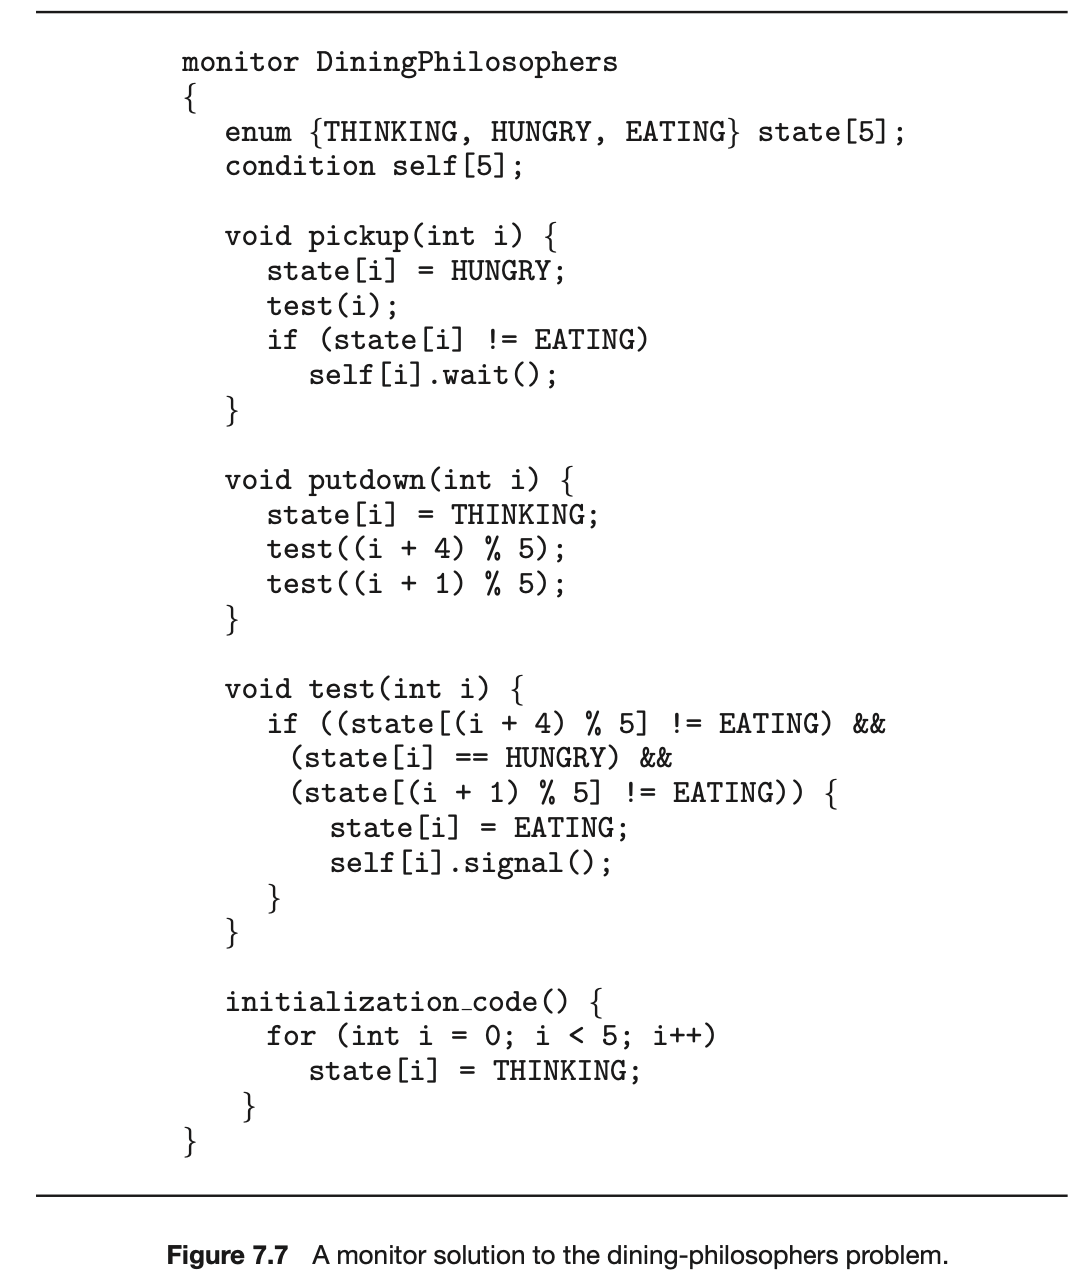
- distribution of the chopsticks is controlled by the monitor __DiningPhilosophers__
    - Before starting to eat, must invoke the operation pickup()
    - After the successful completion of the operation, the philosopher may eat.
    - Following this, the philosopher invokes the putdown() operation
- no two neighbors are eating simultaneously
- no deadlocks will occur
- however,starvation is still possible

#### Method 2 -  Pthread solution to the Dining-Philosophers Problem
```c
#include <stdio.h>
#include <stdlib.h> 
#include <unistd.h> 
#include <pthread.h>

#define true 1
#define NUM_PHILS 5

enum {THINKING, HUNGRY, EATING} state[NUM_PHILS];

pthread_mutex_t mutex_locks;
pthread_cond_t cond_vars[NUM_PHILS];

int leftOf(int i) {
    return (i + NUM_PHILS - 1) % NUM_PHILS;
}

int rightOf(int i) {
    return (i + 1) % NUM_PHILS;
}

void think(int id) {
    printf("%d: Now, I'm thiking...\n", id);
    usleep((1 + rand() % 50) * 10000);
}

void eat(int id) {
    printf("%d: Now, I'm eating...\n", id);
    usleep((1 + rand() % 50) * 10000);
}

void test(int i) {
    // If I'm hungry and my neighbors are not eating, 
    // then let me eat.
    if (state[i] == HUNGRY &&
        state[leftOf(i)] != EATING && state[rightOf(i)] != EATING)
    {
        state[i] = EATING;
        pthread_cond_signal(&cond_vars[i]);
    }
}

void pickup(int i) {
    pthread_mutex_lock(&mutex_lock);
    
    state[i] = HUNGRY;
    test(i);
    while (state[i] != EATING) {
        pthread_cond_wait(&cond_vars[i], &mutex_lock);
    }
    pthread_mutex_unlock(&mutex_lock);
}

void putdown(int i) {
    pthread_mutex_lock(&mutex_lock);
    
    state[i] = THINKING;
    test(leftOf(i));
    test(rightOf(i));
    pthread_mutex_unlock(&mutex_lock);
}

void *philosopher(void *param) {
    int id = *((int *)param);
    while (true) {
        think(id);
        pickup(id);
        eat(id);
        putdown(id);
    } 
}

void init() {
    int i;
    for (i = 0; i < NUM_PHILS; i++) {
        state[i] = THINKING;
        pthread_cond_init(&cond_vars[i], NULL);
    }
    pthread_mutex_init(&mutex_lock, NULL); 
    srand(time(0));
}

int main() {
    int i;
    pthread_t tid;
    init();
    for (i = 0; i < NUM_PHILS; i++)
        pthread_create(&tid, NULL, philosopher, (void *)&i);
    for (i = 0; i < NUM_PHILS; i++)
        pthread_join(tid, NULL);
    return 0;
}

```

#### Method 2 - Java solution to the Dining-Philosophers Problem
```java
import java.util.concurrent.locks.Condition; 
import java.util.concurrent.locks.Lock;
import java.util.concurrent.locks.ReentrantLock;

enum State {
      THINKING, HUNGRY, EATING
}

public class DiningPhilosophers {
    public static void main(String[] args) throws Exception {
        int numOfPhils = 5;
        Philosopher[] philosophers = new Philosopher[numOfPhils]; 
        DiningPhilosopherMonitor monitor = new DiningPhilosopherMonitor(numOfPhils);
        for (int i = 0; i < philosophers.length; i++)
            new Thread(new Philosopher(i, monitor)).start();
    } 
}

class Philosopher implements Runnable {
    
    private int id;
    private DiningPhilosopherMonitor monitor;

    public Philosopher(int id, DiningPhilosopherMonitor monitor) { 
        this.id = id;
        this.monitor = monitor;
    }

    @Override
    public void run() {
        while (true) {
            think();
            monitor.pickup(id);
            eat();
            monitor.putdown(id);
        } 
    }
    
    private void think() {
        try {
            System.out.println(id + ": Now I'm thinking.");
            Thread.sleep((long)(Math.random()*500));
        } catch (InterruptedException e) { }
    }

    private void eat() { 
        try {
            System.out.println(id + ": Now I'm eating.");
            Thread.sleep((long)(Math.random()*50));
        } catch (InterruptedException e) { }
    }
}

class DiningPhilosopherMonitor {
    private int numOfPhils;
    private State[] state;
    private Condition[] self;
    private Lock lock;

    public DiningPhilosopherMonitor(int num) {
        numOfPhils = num;
        state = new State[num];
        self = new Condition[num];
        lock = new ReentrantLock();
        for (int i = 0; i < num; i++) {
            state[i] = State.THINKING;
            self[i] = lock.newCondition();
        }
    }
    
    private int leftOf(int i) {
        return (i + numOfPhils - 1) % numOfPhils;
    }
    
    private int rightOf(int i) { 
        return (i + 1) % numOfPhils;
    }
    
    private void test(int i) { 
        if (state[i] == State.HUNGRY &&
                state[leftOf(i)] != State.EATING &&
                state[rightOf(i)] != State.EATING)
        {
            state[i] = State.EATING; self[i].signal();
        } 
    }
    
    public void pickup(int id) {
        lock.lock();
        try {
            state[id] = State.HUNGRY;
            test(id);
            if (state[id] != State.EATING)
                self[id].await();
        }
        catch (InterruptedException e) {
        }
        finally {
            lock.unlock();
        }
        
    public void putdown(int id) {
        lock.lock();
        try {
            state[id] = State.THINKING;
            test(leftOf(id)); // left neighbor
            test(rightOf(id)); // right neighbor
        }
        finally {
            lock.unlock();
        }
    }
}
```

# 7.5 Alternative Approaches
- Concurrent applications take advantage of multiple processing cores
    - However, concurrent applications present an increased risk of race conditions and liveness hazards such as deadlock
- Techniques such as mutex locks, semaphores, and monitors have been used to address these issues
    - However, as the number of processing cores increases, it becomes increasingly difficult to design multithreaded applications that are free from race conditions and deadlock
- Alternative approaches provided in both programming languages and hardware
    - In order to support the design of thread-safe concurrent applications

### 1. Transactional Memory:
- A memory transaction is a sequence of memory read–write operations that are atomic. 
    - If all operations in a transaction are completed, the memory transaction is committed. 
    - Otherwise, the operations must be aborted and rolled back. 
- The benefits of transactional memory can be obtained through features added to a programming language

#### Transactional memory example
```c
void update(){
    atomic {
        /* modify shared data */
    }
}
```

- Pros 
    - Transactional memory system —not the developer— is responsible for guaranteeing atomicity
    - Deadlock is not possible because no locks are involved
    - Transactional memory system can identify which statements in atomic blocks can be executed concurrently, such as concurrent read access to a shared variable
- Software transactional memory (STM)
    - implements transactional memory exclusively in software — no special hardware is needed
- Hardware transactional memory (HTM) 
    - Uses hardware cache hierarchies and cache coherency protocols to manage and resolve conflicts involving shared data residing in separate processors’ caches
- Cons
    - Transactional memory has existed for several years without widespread implementation

### 2. OpenMP
- __OpenMP Library__ supports of parallel programming in a shared-memory environment
- Thread creation and management are handled by the OpenMP library and are not the responsibility of application developers
- __#pragma omp parallel__
    - identified as a parallel region and is performed by a number of threads equal to the number of processing cores in the system
- __#pragma omp critical__
    - specifies the code region following the directive as a critical section in which only one thread may be active at a time
    
#### OpenMP example
```c
void update(int value){
    #pragma omp critical
    {
        counter += value;
    }
}
```
- Pros
    - Using the critical-section compiler directive in OpenMP is that it is generally considered easier to use than standard mutex locks
- Cons
    - Application developers must still identify possible race conditions and adequately protect shared data using the compiler directive
    - Deadlock is still possible when two or more critical sections are identified because the critical-section compiler directive behaves much like a mutex lock, 

### 3. Functional Programming Language

#### Imperative (or procedural) languages
- C, C++, Java, and C#
- Imperative languages are used for implementing algorithms that are __state-based__
- __Flow of the algorithm__ is crucial to its correct operation, and state is represented with variables and other data structures.
- Program state is __mutable__, as variables may be assigned different values over time.

#### Functional programming languages
- __JAX__, Erlang and Scala
- Functional languages __do not maintain state__
- Once a variable has been defined and assigned a value, its value is __immutable — it cannot change__
- Because functional languages disallow mutable state, they need not be concerned with issues such as race conditions and deadlocks

#### functional programming example
```python
class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())
```
- Imperative (or procedural) prints 1, 2, 3


```python
import jax
import jax.numpy as jnp

counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())
```
- Functional prints 1, 1, 1